# Realizado hoy (21/5)
- Solucionado bug de reporting, que tomaba incorrectamente el valor previo.
- Optimizado el flujo cuando sólo se cambian los parámetros de búsqueda.
- Aprendido shortcut alt + flecha para desplazar líneas de código

# Ideas pendientes

- Incluir: en el gráfico superior (precios), le rentabilidad day to day, y en el inferior (OBV) el volumen como histograma.
- Convertir el precio close en valor intermedio High Low.
- Implementar get_labels en subtítulo de gráfico para tener más información
- Idea de un report general y uno especializado con "más cosas" (RSI, más largo plazo de análisis, etc). No se puede hacer fácilmente invocando la función, hay que o bien repetir o irse a clases.
- Convertir, para ello, filterset en clases.
- Algunas ideas de inversión (LYV, etc)

In [1]:
import pandas as pd
from functions import calc, retrieve, visualize as viz

import warnings
warnings.filterwarnings('ignore')

%colors nocolor

In [2]:
def get_and_store_raw_data(fromCSV, numberOfStocks=50, daysSince=30):
    tickers_df = retrieve.get_tickers(numberOfStocks)
    
    if (fromCSV):
        (rawdata, spreads, volumes) = retrieve.get_from_CSV()
    else:
        downloadedData = retrieve.get_downloaded_data(tickers_df, numberOfStocks, daysSince)
        (rawdata, spreads, volumes, highs, lows) = retrieve.distribute_data(downloadedData)
        retrieve.save_data(rawdata, spreads, volumes)

    return (rawdata, spreads, volumes, tickers_df, highs, lows)
    
def processData(closes, volumes, QUICK_EMA_PERIOD=7, SLOW_EMA_PERIOD=14, latestWindow=2):
    print ("Calculating indicators...")
    companies = closes.columns.values

    EMA_df = calc.get_EMA_df(QUICK_EMA_PERIOD, SLOW_EMA_PERIOD, closes)
    OBV_df= calc.get_OBV_df(volumes, closes)
    keyStats = calc.get_intersection_point(EMA_df, closes)
    (keyStats['avgRatio'], keyStats['MinAbsRatio']) = calc.ratioWrapper(EMA_df, companies, keyStats)
    keyStats['latestGrowth'] = round(closes.pct_change()[-latestWindow:].min(),5)
    keyStats['ratioContr'] = calc.get_stocks_growing_now(closes, keyStats, 3)

    return(EMA_df, OBV_df, keyStats) 

import matplotlib.pyplot as plt

def plot_one_with_obv(x, EMA_df, closes, OBV_df):
    fig, axs = (plt.subplots(2, sharex=True))
    x_axis = closes.index
    axs[0].plot(x_axis, EMA_df['Quick'][x], 'r')
    axs[0].plot(x_axis, EMA_df['Slow'][x], 'b')
    axs[0].plot(x_axis, closes[x], 'g')
    axs[1].plot(x_axis, OBV_df[x], 'g')


def showData(closes, spreads, volumes, EMA_df, OBV_df, keyStats, filterSet, tickers_df):
    filteredCompanies = viz.filter_companies(keyStats, filterSet)
    #filteredCompanies.to_csv("./logs/filteredCompanies_" + pd.to_datetime('today').strftime('%Y%m%d')) 
    viz.plot_all(closes, spreads, volumes, EMA_df, OBV_df, filteredCompanies, tickers_df, keyStats, limit=10)



In [3]:
"""
Filterset Sample. Use 0 or comment for Neutral

filterSet = dict({
    "aboveAvgRatio":1, 
    "aboveMinAbs":1, 
    "minPositivePeriod":4, 
    "ratioContr":1, 
    "latestGrowth":0.8
    })

timeframes dict({
    daysSince,
    qema_period,
    sema_period
    }) 
"""

""" filterSet = dict({
    #"aboveAvgRatio":0.02, 
    "aboveMinAbs":0.0001, 
    #"minPositivePeriod":4, 
    #"ratioContr":1,
    "latestGrowth":0.005
     }) """

def get_reset_mode(numberOfStocks, daysSince, filterSet):
    global  search_params_cache, filter_params_cache, keyStats
    
    search_params_current = dict(numberOfStocks=numberOfStocks, daysSince = daysSince)
    resetMode = 0
    #if (('filter_params_cache' not in globals()) or ('keyStats' not in globals()) or (filterSet != filter_params_cache)): resetMode = 1
    if ('keyStats' not in globals()): resetMode = 1
    if (('search_params_cache' not in globals()) or ('closes' not in globals()) or (search_params_current != search_params_cache)): resetMode = 2

    search_params_cache = search_params_current
    filter_params_cache = filterSet
    #print (f"Reset mode is {resetMode}")
    return (resetMode)

def find_stocks(filterSet, numberOfStocks=500, daysSince=30):
    global closes, spreads, volumes, EMA_df, OBV_df, keyStats, tickers_df

    resetMode = get_reset_mode(numberOfStocks=numberOfStocks, daysSince=daysSince, filterSet=filterSet)
    fromCSV = False

    if (resetMode == 2):
        print ("Raw data did not exist or search params were changed. Downloading...")
        fromCSV = retrieve.from_CSV(daysSince, numberOfStocks)
        #fromCSV = True #Overriding
        (closes, spreads, volumes, tickers_df, highs, lows)= get_and_store_raw_data(fromCSV=fromCSV, numberOfStocks=numberOfStocks, daysSince=daysSince)

    if (resetMode >= 1):
        print ("Filters and processed data did not exist or search params were changed. Processing...")
        (EMA_df, OBV_df, keyStats) = processData(closes, volumes, QUICK_EMA_PERIOD=7, SLOW_EMA_PERIOD=14, latestWindow=2)


    showData(closes, spreads, volumes, EMA_df, OBV_df, keyStats, filterSet, tickers_df)
    
    return (closes, spreads, volumes, EMA_df, keyStats, tickers_df, highs, lows)

#(closes, spreads, EMA_df, keyStats) = find_stocks(filterSet)



Raw data did not exist or search params were changed. Downloading...
Is it possible to use cached data? False
Initiating download...
--> Requested days: 30.
--> Requested stocks: 500.
[*********************100%***********************]  500 of 500 completed

2 Failed downloads:
- FDX: No data found for this date range, symbol may be delisted
- MCHP: No data found for this date range, symbol may be delisted
Filters and processed data did not exist or search params were changed. Processing...
Calculating indicators...
--> EMA Dataframe calculated.
--> Intersection points found.
--> Absolute and Relative Mins calculated.
Starting filtering...
--> Main companies filtered. 31 outstanding companies.
Displaying 10 first companies
Max spread of LYV is 0.06959567770496433
Max spread of VMC is 0.06255590297293323
Max spread of TSLA is 0.06042391602233753
Max spread of NOW is 0.06816481373053249
Max spread of CAH is 0.04800203878409182
Max spread of PTC is 0.059023828404804524
Max spread of FFIV i

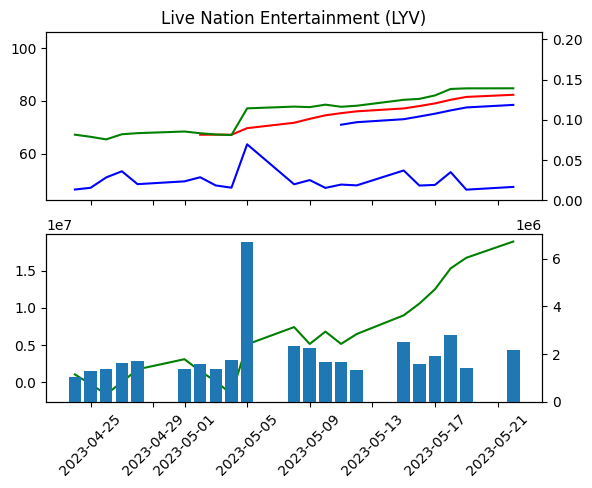

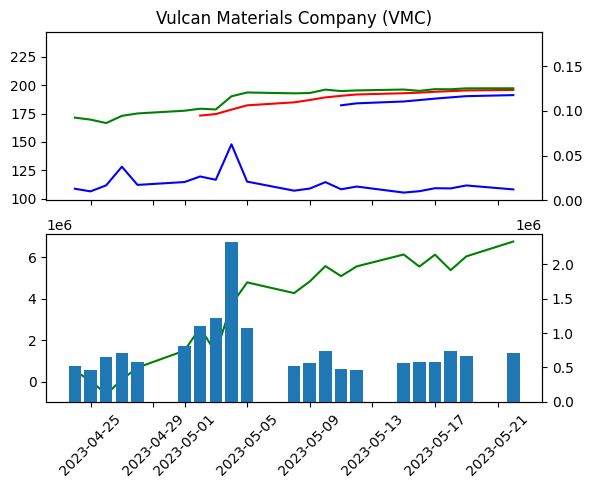

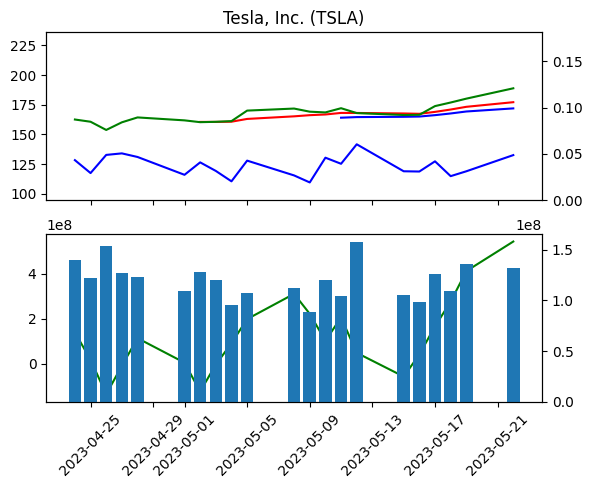

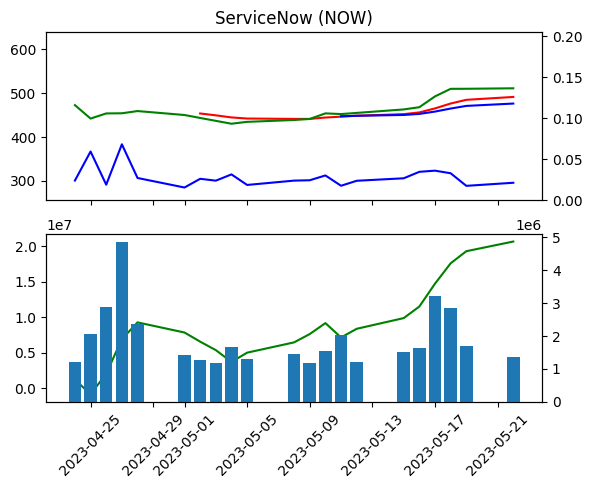

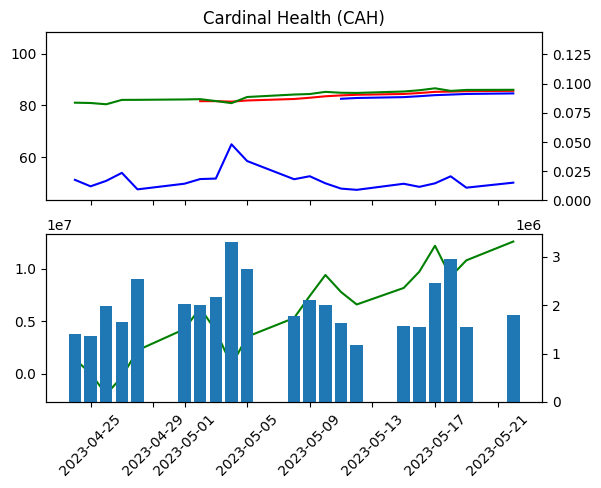

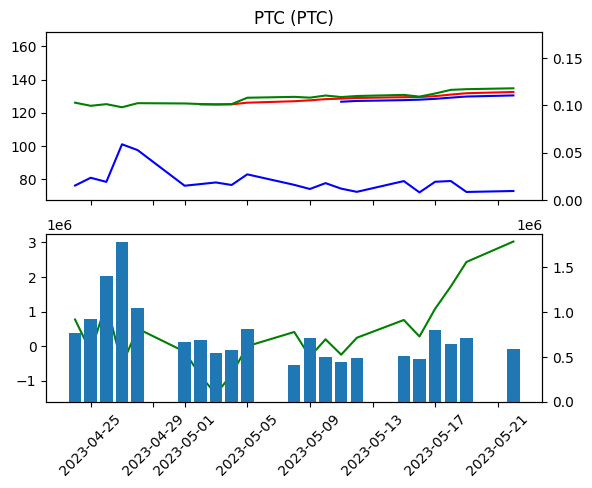

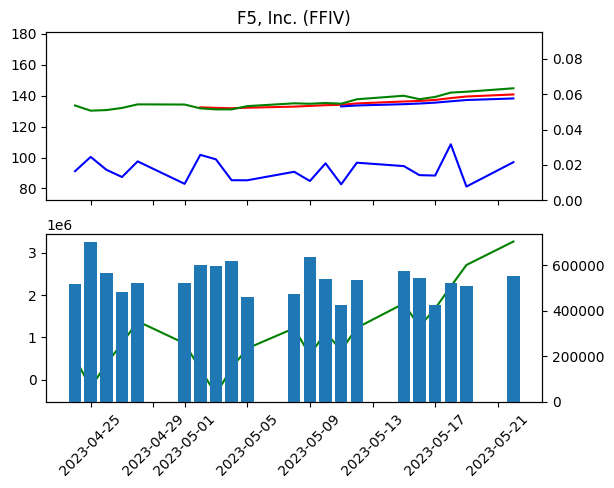

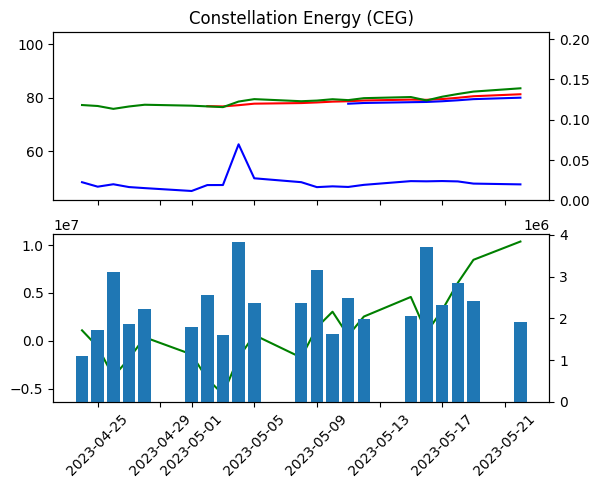

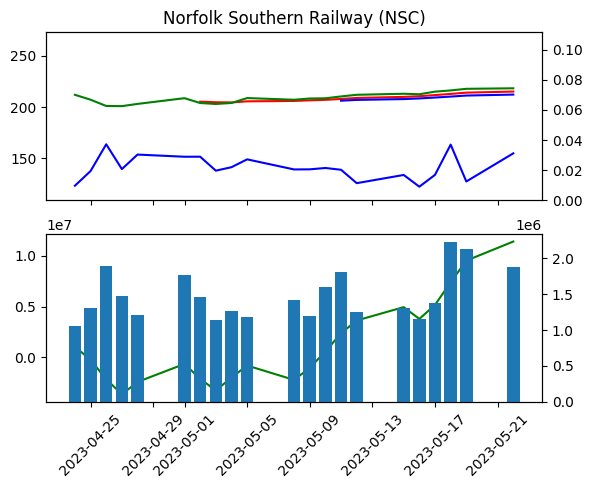

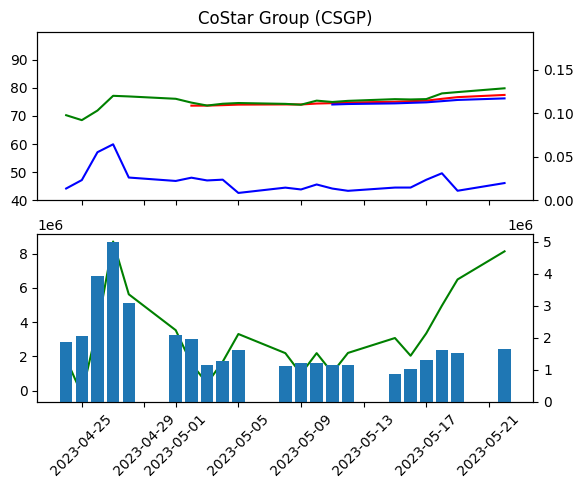

In [13]:

(closes, spreads, volumes, EMA_df, keyStats, tickers_df, highs, lows) = find_stocks(numberOfStocks=500, daysSince=30, filterSet=dict({
    #"aboveAvgRatio":0.02, 
    "aboveMinAbs":0.0001, #Originally 0.0001 
    #"minPositivePeriod":4, 
    "ratioContr":0,
    "latestGrowth":0 #Originally 0.005
     }))

In [ ]:
#import matplotlib.pyplot as plt

#fig, axs = (plt.subplots(2))
#x_axis = closes.index
#axs[0].bar([x_axis], volumes['LYV'], 'b')
#axs[0].bar(x_axis, volumes['LYV'])


In [ ]:
x_axis.values

NameError: name 'x_axis' is not defined

In [ ]:
volumes['LYV'].values

array([1051600, 1311200, 1357100, 1628400, 1725800, 1357900, 1603200,
       1371500, 1734400, 6701000, 2323600, 2266000, 1663000, 1656800,
       1329400, 2511100, 1575500, 1934600, 2806400, 1421500, 2181800])

In [ ]:
type(closes.index.values
    )

numpy.ndarray

In [ ]:
import talib

test = talib.RSI(closes['ABBV'])

In [ ]:
difference = (OBV_df[-5:].mean()-OBV_df.mean())
ratio = difference /(OBV_df.mean().abs())
finalList = ratio.sort_values(ascending=False)
finalList

EQT       683.362368
COP       279.363523
FTNT       23.313124
GOOGL      22.420287
LRCX       20.931214
            ...     
MHK      -101.480306
EMN      -122.603797
DHR      -220.456798
HSY      -463.922254
PM      -1066.990009
Length: 500, dtype: float64

In [ ]:
OBV_df[testcompany][-5:]


NameError: name 'testcompany' is not defined

In [ ]:
testcompany = 'EXPE'
print(f"Últimos 5 días: {OBV_df[testcompany][-5:].mean()}, Rango total: {OBV_df[testcompany].mean()}")

In [ ]:
plot_one_with_obv(testcompany, EMA_df, closes, OBV_df)

In [ ]:
OBV_df.mean()

In [ ]:
OBV_df= calc.get_OBV_df(volumes, closes)

In [ ]:
#This should probably be a class for reuse.
#Failed attempt to get a more detailed view of a stock, because when it's only 1 stock to be downloaded, we get a series and not a dataframe, causing lots of errors.

import pandas as pd
import yfinance as yf

def wider_look(company, range):
    (ts_today, ts_origin) = retrieve.get_timestamps(range)
    (closes, spreads, volumes) = retrieve.distribute_data(yf.download(company, start=ts_origin, end=ts_today).fillna(0))
    EMA_df = calc.get_EMA_df(14, 26, closes)
    OBV_df= calc.get_OBV_df(volumes, closes)
    keyStats = calc.get_intersection_point(EMA_df, closes)
    plot_one_with_obv(company, EMA_df, closes, OBV_df)
    return (keyStats)

keyStats_test = wider_look('LYV LYV', 60)

In [ ]:
closes.index

Index(['2023-04-21', '2023-04-24', '2023-04-25', '2023-04-26', '2023-04-27',
       '2023-04-28', '2023-05-01', '2023-05-02', '2023-05-03', '2023-05-04',
       '2023-05-05', '2023-05-08', '2023-05-09', '2023-05-10', '2023-05-11',
       '2023-05-12', '2023-05-15', '2023-05-16', '2023-05-17', '2023-05-18',
       '2023-05-19'],
      dtype='object', name='Date')

In [ ]:
closes.index[int(round((len(closes.index)/2),0))]

'2023-05-05'

In [ ]:
closes.pct_change()['A']

Date
2023-04-24         NaN
2023-04-25   -0.040020
2023-04-26   -0.017073
2023-04-27    0.012369
2023-04-28    0.019571
2023-05-01    0.009320
2023-05-02   -0.005423
2023-05-03   -0.000921
2023-05-04   -0.005052
2023-05-05   -0.009192
2023-05-08   -0.005088
2023-05-09   -0.045496
2023-05-10    0.004727
2023-05-11   -0.007410
2023-05-12    0.008058
2023-05-15   -0.001058
2023-05-16   -0.006864
2023-05-17    0.001501
2023-05-18    0.008873
2023-05-19    0.012782
2023-05-22   -0.004053
Freq: B, Name: A, dtype: float64